In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine-translation-chinese-and-english/english.en
/kaggle/input/machine-translation-chinese-and-english/chinese.zh


## Load Data

In [2]:
def load_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        # replace '\n' with ' '
        data = pd.Series(f.readlines())
        data = data.str.replace('\n', ' ')
    return data

In [3]:
data_ZH = load_data('../input/machine-translation-chinese-and-english/chinese.zh')
data_EN = load_data('../input/machine-translation-chinese-and-english/english.en')
raw_data = pd.DataFrame({'zh': data_ZH, 'en': data_EN})
raw_data.head()

,zh,en
0,1929年还是1989年?,1929 or 1989?
1,巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正...,PARIS – As the economic crisis deepens and wid...
2,一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为...,"At the start of the crisis, many people likene..."
3,如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政...,"Today, the mood is much grimmer, with referenc..."
4,目前的趋势是，要么是过度的克制（欧洲），要么是努力的扩展（美国）。,The tendency is either excessive restraint (Eu...


## Process data

In [4]:
import re
def is_valid_sentence(text):
    pattern = r"^(?=.*[a-zA-Z])|(?=.*\d).+$"
    return bool(re.match(pattern, text))

#create a new boolean row to indicate which datarow has english char/number
raw_data["in_valid"] = raw_data["zh"].apply(is_valid_sentence)

#filter out rows where the condition is True
data = raw_data[~raw_data["in_valid"]]

#drop the boolean columns
data = data.drop(columns=["in_valid"]).reset_index().drop(columns=["index"])
display(data)

,zh,en
0,巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正...,PARIS – As the economic crisis deepens and wid...
1,目前的趋势是，要么是过度的克制（欧洲），要么是努力的扩展（美国）。,The tendency is either excessive restraint (Eu...
2,欧洲在避免债务和捍卫欧元的名义下正变得谨慎，而美国已经在许多方面行动起来，以利用这一理想的时...,Europe is being cautious in the name of avoidi...
3,当然，雷曼兄弟公司的倒闭和柏林墙的倒塌没有任何关系。,"Of course, the fall of the house of Lehman Bro..."
4,事实上，从表面上看，两者似乎是完全是相反的：一个是象征着压抑和人为分裂的柏林墙的倒塌，而另一...,"Indeed, on the surface it seems to be its perf..."
...,...,...
199199,事实上，他们应该推动所有边缘群体获得平等权利。,"Indeed, they should advance equality for all m..."
199200,寨卡的中长期后果比依靠这样的思路来解决。,Zika’s medium- and long-term consequences must...
199201,当妇女生下因为寨卡病毒而存在先天性疾病的儿童时，其应对手段应该基于尊严、价值观和个体权利。,When a woman gives birth to a child with a con...
199202,应该认识到，现在的程序让一些个体和群体陷入了贫困，剥夺了他们的基本公民权利。,It should acknowledge the processes that keep ...


In [5]:
data["en"] = data["en"].apply(lambda x: str(x).lower())
data.head()

,zh,en
0,巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正...,paris – as the economic crisis deepens and wid...
1,目前的趋势是，要么是过度的克制（欧洲），要么是努力的扩展（美国）。,the tendency is either excessive restraint (eu...
2,欧洲在避免债务和捍卫欧元的名义下正变得谨慎，而美国已经在许多方面行动起来，以利用这一理想的时...,europe is being cautious in the name of avoidi...
3,当然，雷曼兄弟公司的倒闭和柏林墙的倒塌没有任何关系。,"of course, the fall of the house of lehman bro..."
4,事实上，从表面上看，两者似乎是完全是相反的：一个是象征着压抑和人为分裂的柏林墙的倒塌，而另一...,"indeed, on the surface it seems to be its perf..."


In [6]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.data.metrics import bleu_score

import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
from typing import Iterable, List
from torch import Tensor
from torchtext.vocab import Vocab
from torchtext._torchtext import Vocab as VocabPybind
print(torch.__version__)
import math

2.1.2


In [7]:
# for reproducibility
# refer https://pytorch.org/docs/stable/notes/randomness.html
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load tokenizer

In [8]:
%%capture
!python -m spacy download zh_core_web_sm
!python -m spacy download en_core_web_sm

In [9]:
token_transform = {}
SRC_LANGUAGE = 'zh'
TGT_LANGUAGE = 'en'
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='zh_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

## Build vocabulary

In [10]:
from torchtext.vocab import build_vocab_from_iterator

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

def yield_tokens(iterator, language):
    assert language in [SRC_LANGUAGE, TGT_LANGUAGE]
    for sentence in iterator:
        token = token_transform[language](str(sentence))
        yield token

vocab_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    token = yield_tokens(data[ln], ln)
    vocab_transform[ln] = build_vocab_from_iterator(token, specials=special_symbols, min_freq=1, special_first=True)
    
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
      vocab_transform[ln].set_default_index(UNK_IDX)

In [11]:
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
print(f'Vocab size of source language is {SRC_VOCAB_SIZE}')
print(f'Vocab size of target language is {TGT_VOCAB_SIZE}')

Vocab size of source language is 72265
Vocab size of target language is 44541


In [12]:
print(vocab_transform[SRC_LANGUAGE].lookup_token(50))
print(vocab_transform[TGT_LANGUAGE].lookup_token(100))

他
much


## Construct transformation piplines

In [13]:
# Test transform
class TransformPipline():
    def __init__(self, token_transform,
                  vocab_transform,
                  tensor_first=True, 
                  bos_token=BOS_IDX,
                  eos_token=EOS_IDX, 
                  pad_token=PAD_IDX,
                  src_max_len=100,
                  tgt_max_len=100):
        assert (token_transform is not None) and (vocab_transform is not None)
        self.SRC_LANGUAGE = SRC_LANGUAGE
        self.TGT_LANGUAGE = TGT_LANGUAGE
        self.token_transform = token_transform
        self.vocab_transform = vocab_transform
        
        self.tensor_first = tensor_first
        self.pad_token = pad_token
        self.src_max_len = src_max_len
        self.tgt_max_len = tgt_max_len
        self.bos_token = bos_token
        self.eos_token = eos_token
        
        self.transforms = {}
        for ln in [self.SRC_LANGUAGE, self.TGT_LANGUAGE]:
            self.transforms[ln] = [self.token_transform[ln], self.vocab_transform[ln]]
            if self.tensor_first:
                self.transforms[ln].append(self.tensor_transform)
            if self.bos_token is not None:
                self.transforms[ln].append(self.insert_bos)
            if self.eos_token is not None:
                self.transforms[ln].append(self.insert_eos)
        
        # For training time, tensor transform for both SOURCE and TARGET lanuageS need add both BOS and EOS
        self.text_transform = {}
        for ln in [self.SRC_LANGUAGE, self.TGT_LANGUAGE]:
            self.text_transform[ln] = self.transform_pipline(*[self.transforms[ln][i] for i in range(len(self.transforms[ln]))]) 
        
    def transform(self, data):
        src, tgt = [], []
        for src_sample, tgt_sample in zip(data[self.SRC_LANGUAGE], data[self.TGT_LANGUAGE]):
            src_token = self.text_transform[self.SRC_LANGUAGE](src_sample.rstrip("\n"))
            tgt_token = self.text_transform[self.TGT_LANGUAGE](tgt_sample.rstrip("\n"))
            if self.pad_token is not None:
                src_token = self.add_pad(src_token, src_max_len)
                tgt_token = self.add_pad(tgt_token, tgt_max_len)
            src.append(src_token)
            tgt.append(tgt_token)
        src = torch.stack(src)
        tgt = torch.stack(tgt)
        return src, tgt

    def tensor_transform(self, token_ids: List):
        return torch.tensor(token_ids)
    
    def insert_bos(self, token_ids):
        if torch.is_tensor(token_ids):
            return torch.cat((torch.tensor([self.bos_token]), token_ids))
        else:
            return token_ids.insert(0, self.bos_token)
    def insert_eos(self, token_ids):
        if torch.is_tensor(token_ids):
            return torch.cat((token_ids, torch.tensor([self.eos_token])))
        else:
            return token_ids.append(self.eos_token)
    def add_pad(self, token_ids, max_len):
        """
        Add padding to the end of the sequence
        """
        assert max_len is not None
        
        if torch.is_tensor(token_ids):
            valid_len = token_ids.size(0)
        else:
            valid_len = len(token_ids)
        assert max_len >= valid_len
        padding_len = max_len - valid_len
        
        if self.tensor_first == True:
            padding = torch.tensor([self.pad_token]*padding_len)
            return torch.cat((token_ids, padding))
        else:
            padding = [self.pad_token]*padding_len
            return token_ids + padding
    
    def transform_pipline(self, *transforms):
        def func(txt_input):
            for transform in transforms:
                txt_input = transform(txt_input)
            return txt_input
        return func

In [14]:
src_max_len = 200
tgt_max_len = 200
trans_pipline = TransformPipline(token_transform, vocab_transform, tensor_first=True, 
                          bos_token=BOS_IDX, eos_token=EOS_IDX, pad_token=PAD_IDX, 
                                 src_max_len=src_max_len, tgt_max_len=tgt_max_len)

## Prepare Data

In [15]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=50, shuffle=True)
val_set, test_set = train_test_split(test_set, test_size=0.5, random_state=50, shuffle=True)

print(len(train_set)), print(len(val_set)), print(len(test_set))

159363
19920
19921


(None, None, None)

In [16]:
train_set_transform = trans_pipline.transform(train_set)
val_set_transform = trans_pipline.transform(val_set)
test_set_transform = trans_pipline.transform(test_set)

#train_set_transform = torch.load("train_set_transform.pt")
#val_set_transform = torch.load("val_set_transform.pt")
#test_set_transform = torch.load("test_set_transform.pt")

In [17]:
from torch.utils.data import Dataset, DataLoader

class Textdataset(Dataset):
    
    def __init__(self, src, tgt):
        self.src = src
        self.tgt = tgt

    def __len__(self):
        return len(self.tgt)

    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]


In [18]:
# Create data loader, batch dataset

train_set = Textdataset(train_set_transform[0], train_set_transform[1])
val_set = Textdataset(val_set_transform[0], val_set_transform[1])
test_set = Textdataset(test_set_transform[0], test_set_transform[1])

batch_size = 30
train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size, shuffle=False)
train_iterator = iter(train_loader)
val_iterator = iter(val_loader)
test_iterator = iter(test_loader)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 5313
Number of validation batches: 664


# Develop Model

## Attention Mechanism
ref: https://colab.research.google.com/github/jaygala24/pytorch-implementations/blob/master/Attention%20Is%20All%20You%20Need.ipynb

![transformer_model](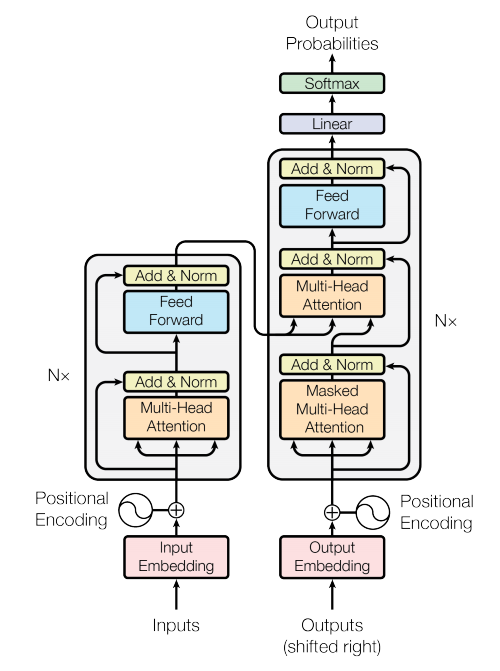 "Transformer Model")

(source: https://arxiv.org/pdf/1706.03762.pdf)


In [19]:
class ScaledDotProductAttention(nn.Module):
    """ Computes scaled dot product attention
    """

    def __init__(self, scale, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = scale
        self.dropout_rate = dropout_rate

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, n_heads, query_len, head_dim)
            key: (batch_size, n_heads, key_len, head_dim)
            value: (batch_size, n_heads, value_len, head_dim)
            mask: (batch_size, 1, 1, source_seq_len) for source mask
                  (batch_size, 1, target_seq_len, target_seq_len) for target mask
        """
        # calculate alignment scores
        scores = torch.matmul(query, key.transpose(-2, -1))  # (batch_size, n_heads, query_len, value_len)
        scores = scores / self.scale  # (batch_size, num_heads, query_len, value_len)

        # mask out invalid positions
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))  # (batch_size, n_heads, query_len, value_len)

        # calculate the attention weights (prob) from alignment scores
        attn_probs = F.softmax(scores, dim=-1)  # (batch_size, n_heads, query_len, value_len)

        # calculate context vector
        output = torch.matmul(self.dropout(attn_probs), value)  # (batch_size, n_heads, query_len, head_dim)

        # output: (batch_size, n_heads, query_len, head_dim)
        # attn_probs: (batch_size, n_heads, query_len, value_len)
        return output, attn_probs

### Multi-Head Attention Module


![multi_head_attention](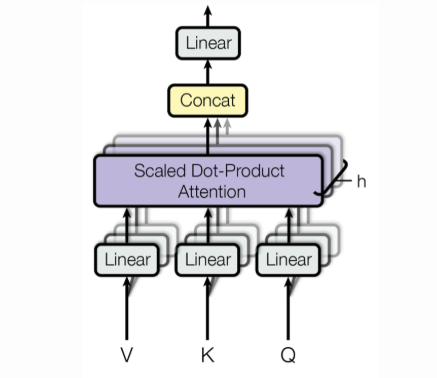 "Multi-Head Attention Block")

(source: https://arxiv.org/pdf/1706.03762.pdf)


In [20]:
class MultiHeadAttention(nn.Module):
    """ Implements Multi-Head Self-Attention proposed by Vaswani et al., 2017.
        refer https://arxiv.org/abs/1706.03762
    """

    def __init__(self, d_model, n_heads, dropout_rate=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "`d_model` should be a multiple of `n_heads`"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = self.d_v = d_model // n_heads  # head_dim
        self.dropout_rate = dropout_rate

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(np.sqrt(self.d_k), dropout_rate)


    def split_heads(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_k)

        # x: (batch_size, n_heads, seq_len, head_dim)
        return x


    def group_heads(self, x):
        """ x: (batch_size, n_heads, seq_len, head_dim)
        """
        batch_size = x.size(0)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)

        # x: (batch_size, seq_len, d_model)
        return x


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, query_len, d_model)
            key: (batch_size, key_len, d_model)
            value: (batch_size, value_len, d_model)
            mask: (batch_size, 1, source_seq_len) for source mask
                  (batch_size, target_seq_len, target_seq_len) for target mask
        """
        # apply linear projections to query, key and value
        Q = self.split_heads(self.W_q(query))  # (batch_size, n_heads, query_len, head_dim)
        K = self.split_heads(self.W_k(key))  # (batch_size, n_heads, key_len, head_dim)
        V = self.split_heads(self.W_v(value))  # (batch_size, n_heads, value_len, head_dim)

        if mask is not None:
            # apply same mask for all the heads
            mask = mask.unsqueeze(1)

            # mask: (batch_size, 1, 1, source_seq_len) for source mask
            #       (batch_size, 1, target_seq_len, target_seq_len) for target mask

        # calculate attention weights and context vector for each of the heads
        x, attn = self.attention(Q, K, V, mask)

        # x: (batch_size, n_heads, query_len, head_dim)
        # attn: (batch_size, n_heads, query_len, value_len)

        # concatenate context vector of all the heads
        x = self.group_heads(x)  # (batch_size, query_len, d_model)

        # apply linear projection to concatenated context vector
        x = self.W_o(x)  # (batch_size, query_len, d_model)

        # x: (batch_size, query_len, d_model)
        # attn: (batch_size, n_heads, query_len, value_len)
        return x, attn

### Position-wise Feed-Forward Network Module

This is the another block in the encoder as well as decoder layer which transforms from $d_{model}$ to $d_{ff}$ and then again to $d_{model}$. The same linear transformation is applied across different positions. This can also be viewed as two convolutions with filter size 1.

$$
FFN(x) = max(0, xW_1 + b_1)W_2 + b_2
$$

Position-wise Feed-Forward Network returns the following:
- `x`: non-linearity transformed vector of dimension same as input


In [21]:
class PositionwiseFeedForward(nn.Module):
    """ Implements a two layer feed-forward network.
    """

    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout_rate = dropout_rate

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = self.dropout(F.relu(self.w_1(x)))  # (batch_size, seq_len, d_ff)
        x = self.w_2(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

### Positional Encoding Module

Since the transformer contains no recurrence and no convolutions, we need some way to inject information about relative or absolute position to assign order to tokens in the sequence. Sinusoidal positional encodings are used with different frequencies to unique represent the order and the position of the token in sequence.

$$
\begin{aligned}
\text{PE}_{(pos, 2i)} &= \text{sin}(\frac{pos}{10000^{2i/d_{model}}}) \\
\text{PE}_{(pos, 2i + 1)} &= \text{cos}(\frac{pos}{10000^{2i/d_{model}}})
\end{aligned}
$$

where $pos$ is the position and $i$ is the dimension.

> _We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. (Excerpt from [Attention is All You Need paper](https://arxiv.org/pdf/1706.03762.pdf))_

Positional Encoding Module returns the following:
- `x`: word embedding of the token in the sequence with inherent position information


In [22]:
class PositionalEncoding(nn.Module):
    """ Implements the sinusoidal positional encoding.
    """

    def __init__(self, d_model, dropout_rate=0.1, max_len=200):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.dropout = nn.Dropout(dropout_rate)

        # compute positional encodings
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # (d_model,)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:x.size(0), :]  # (batch_size, seq_len, d_model)
        x = self.dropout(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

### Encoder Module


The encoder consists of a stack of $N = 3$ (6 in original paper) identical layers, each containing two sub-layers, a multi-head self-attention layer, and a position-wise fully connected feed-forward network. Each sub-layer has a residual connection and layer normalization.

Encoder returns the following:
- `x`: encoded sequence representation using self-attention


In [23]:
class EncoderLayer(nn.Module):
    """ Encoder is made up of a self-attention layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len, d_model)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x, mask)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

In [24]:
class Encoder(nn.Module):
    """ Encoder block is a stack of N identical encoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=200):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, source_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, source_seq_len, d_model)

        for layer in self.layers:
            x = layer(x, mask)  # (batch_size, source_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

### Decoder Module

The decoder is quite similar to the encoder, except that the decoder contains two multi-head self-attention layers instead of a single layer in a stack of $N = 3$ (6 in original paper) identical layers. The first multi-head self-attention layer attends to decoder outputs generated so far and is masked in order to prevent positions from attending to future positions, whereas the second multi-head self-attention layer attends over the encoder stack output.

Decoder returns the following:
- `x`: output sequence representation using self-attention
- `attn`: alignment scores (attention weights) between input sequence and output sequence


In [25]:
class DecoderLayer(nn.Module):
    """ Decoder is made up of a self-attention layer, a encoder-decoder attention
        layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.enc_attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model)
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x, tgt_mask)  # (batch_size, target_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # apply encoder-decoder attention
        # memory is the output from encoder block (encoder states)
        x1, attn = self.enc_attn_layer(x, memory, memory, src_mask)

        # x1: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, target_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

In [26]:
class Decoder(nn.Module):
    """ Decoder block is a stack of N identical decoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=200):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, memory, src_mask, tgt_mask):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model)
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        for layer in self.layers:
            x, attn = layer(x, memory, src_mask, tgt_mask)  # (batch_size, target_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

### Transformer

The input and output sequences are embedded into a $d_{model}$ dimensional space, which is the usual step before feeding the sequence into the neural network. Positional encoding is also applied to the embedded sequence, which gives a sense of order in the sequence. Encoder encodes the input sequence and generates encoded representation using self-attention mechanism. The decoder uses this representation along with the sequence generated so far to compute the output sequence.

The Transformer returns the following:
- `output`: output sequence generated
- `attn`: alignment scores (attention weights) between input sequence and output sequence


In [27]:
class Transformer(nn.Module):
    """ Transformer wrapper for encoder and decoder.
    """

    def __init__(self, encoder, decoder, generator, pad_idx):
        super(Transformer, self).__init__()
        self.pad_idx = pad_idx

        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator


    def get_pad_mask(self, x, pad_idx=PAD_IDX):
        """ x: (batch_size, seq_len)
        """
        x = (x != pad_idx).unsqueeze(-2)  # (batch_size, 1, seq_len)

        # x: (batch_size, 1, seq_len)
        return x


    def get_subsequent_mask(self, x):
        """ x: (batch_size, seq_len)
        """
        seq_len = x.size(1)
        subsequent_mask = np.triu(np.ones((1, seq_len, seq_len)), k=1).astype(np.int8)  # (batch_size, seq_len, seq_len)
        subsequent_mask = (torch.from_numpy(subsequent_mask) == 0).to(x.device)  # (batch_size, seq_len, seq_len)


        # subsequent_mask: (batch_size, seq_len, seq_len)
        return subsequent_mask


    def forward(self, src, tgt):
        """ src: (batch_size, source_seq_len)
            tgt: (batch_size, target_seq_len)
        """
        # create masks for source and target
        src_mask = self.get_pad_mask(src, self.pad_idx)
        tgt_mask = self.get_pad_mask(tgt, self.pad_idx) & self.get_subsequent_mask(tgt)

        # src_mask: (batch_size, 1, seq_len)
        # tgt_mask: (batch_size, seq_len, seq_len)

        # encode the source sequence
        enc_output = self.encoder(src, src_mask)  # (batch_size, source_seq_len, d_model)

        # decode based on source sequence and target sequence generated so far
        dec_output, attn = self.decoder(tgt, enc_output, src_mask, tgt_mask)

        # dec_output: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)

        # apply linear projection to obtain the output distribution
        output = self.generator(dec_output)  # (batch_size, target_seq_len, vocab_size)

        # output: (batch_size, target_seq_len, vocab_size)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return output, attn

In [28]:
class Generator(nn.Module):
    """ Linear projection layer for generating output distribution.
    """

    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)


    def forward(self, x):
        """ x: (batch_size, target_seq_len, d_model)
        """
        # apply linear projection followed by softmax to obtain output distribution
        x = self.proj(x)  # (batch_size, target_seq_len, vocab_size)
        output = F.log_softmax(x, dim=-1)  # (batch_size, target_seq_len)

        # output: (batch_size, target_seq_len)
        return output

## Helper Utilities

In [29]:
def model_summary(model):
    print(model)
    print(f'# of trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
    print(f'# of non-trainable params: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}')

In [30]:
def convert_ids_to_text(ids, vocab):
    """ Converts token ids to text.
    """
    if ids.dim() == 1:
        ids = ids.tolist()
        output_tokens = vocab.lookup_tokens(ids)
        return output_tokens

    elif ids.dim() == 2:
        return [convert_ids_to_text(ids[i, :], vocab) for i in range(ids.size(0))]

    raise RuntimeError(f'ids has {ids.size()} dimensions, expected 2 dimensions')

In [31]:
class NoamOptim(object):
    """ Optimizer wrapper for learning rate scheduling.
    """

    def __init__(self, optimizer, d_model, factor, n_warmup_steps):
        self.optimizer = optimizer
        self.d_model = d_model
        self.factor = factor
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def zero_grad(self):
        self.optimizer.zero_grad()


    def step(self):
        self.n_steps += 1
        lr = self.get_lr()
        for p in self.optimizer.param_groups:
            p['lr'] = lr
        self.optimizer.step()


    def get_lr(self):
        return self.factor * (
            self.d_model ** (-0.5)
            * min(self.n_steps ** (-0.5), self.n_steps * self.n_warmup_steps ** (-1.5))
        )

## Training


In [32]:
def train_fn(model, iterator, optimizer, critertion, clip=1.0):
    model.train()
    total_loss = 0
    steps = 0

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)
    for idx, batch in enumerate(tk0):
        source, target= batch
        source, target = source.to(device), target.to(device)

        # source: (batch_size, source_seq_len), source_lengths: (batch_size)
        # target: (batch_size, target_seq_len), target_lengths: (batch_size)

        # forward pass
        optimizer.zero_grad()
        output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)

        # calculate the loss
        loss = criterion(
            output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
            target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
        )
        total_loss += loss.item()
        steps += 1

        output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)

        # backward pass
        loss.backward()

        # clip gradients to avoid exploding gradients issue
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        # update model parameters
        optimizer.step()

        tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))

    return output, perplexity

In [33]:
def eval_fn(model, iterator, criterion):
    model.eval()
    total_loss = 0.0
    steps = 0
    hypotheses = []
    references = []

    tk0 = tqdm(iterator, total=len(iterator), position=0, leave=True)

    for idx, batch in enumerate(tk0):
        with torch.no_grad():
            source, target= batch
            source, target = source.to(device), target.to(device)

            # source: (batch_size, source_seq_len), source_lengths: (batch_size)
            # target: (batch_size, target_seq_len), target_lengths: (batch_size)

            # forward pass
            optimizer.zero_grad()
            output, _ = model(source, target[:, :-1])  # (batch_size, target_seq_len - 1, vocab_size)

            # calculate the loss
            loss = criterion(
                output.view(-1, output.size(-1)),  # (batch_size * (target_seq_len - 1), vocab_size)
                target[:, 1:].contiguous().view(-1)  # (batch_size * (target_seq_len - 1))
            )
            total_loss += loss.item()
            steps += 1

            output = output.argmax(dim=-1)  # (batch_size, target_seq_len - 1)
            target = target[:, 1:]  # (batch_size, target_seq_len - 1)

            # converting the ids to tokens (used later for calculating BLEU score)
            pred_tokens = convert_ids_to_text(output, vocab_transform[TGT_LANGUAGE])
            target_tokens = convert_ids_to_text(target, vocab_transform[TGT_LANGUAGE])

            hypotheses += pred_tokens
            references += [[token] for token in target_tokens]

            tk0.set_postfix(loss=total_loss/steps)

    tk0.close()

    perplexity = np.exp(total_loss / len(iterator))
    bleu4 = bleu_score(hypotheses, references)

    return output, perplexity, bleu4

In [34]:
# hyperparameters
INPUT_SIZE = len(vocab_transform[SRC_LANGUAGE])  # source vocab size
OUTPUT_SIZE = len(vocab_transform[TGT_LANGUAGE])  # target vocab size
HIDDEN_SIZE = 512
N_LAYERS = 6
N_HEADS = 8
FF_SIZE = 2048
DROPOUT_RATE = 0.1
N_EPOCHS = 10
CLIP = 1.0

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
decoder = Decoder(OUTPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
generator = Generator(HIDDEN_SIZE, OUTPUT_SIZE)

model = Transformer(encoder, decoder, generator, PAD_IDX).to(device)
model_summary(model)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(72265, 512, padding_idx=1)
    (pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (attn_layer): MultiHeadAttention(
          (W_q): Linear(in_features=512, out_features=512, bias=False)
          (W_k): Linear(in_features=512, out_features=512, bias=False)
          (W_v): Linear(in_features=512, out_features=512, bias=False)
          (W_o): Linear(in_features=512, out_features=512, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (attn_layer_norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ff_layer): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, in

In [36]:
for params in model.parameters():
    if params.dim() > 1:
        nn.init.xavier_uniform_(params)

In [37]:
optimizer = NoamOptim(
    optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9),
    model.encoder.d_model, 2, 4000
)

In [38]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [39]:
#torch.save(vocab_transform, "vocab_transform.pt")
#torch.save(token_transform, "token_transform.pt")
#torch.save(train_set_transform, "train_set_transform.pt")
#torch.save(val_set_transform, "val_set_transform.pt")
#torch.save(test_set_transform, "test_set_transform.pt")

In [40]:
best_bleu4 = float('-inf')
es_patience = 4
patience = 0
model_path = 'model.pth'


for epoch in range(0, N_EPOCHS + 1):
    t_loader = train_loader
    v_loader = val_loader
    # one epoch training
    out, train_perplexity = train_fn(model, t_loader, optimizer, criterion, CLIP)

    # one epoch validation
    out, val_perplexity, val_bleu4 = eval_fn(model, v_loader, criterion)

    print(f'Epoch: {epoch}, Train perplexity: {train_perplexity:.4f}, Valid perplexity: {val_perplexity:.4f}, Valid BLEU4: {val_bleu4:.4f}')

    # early stopping
    is_best = val_bleu4 > best_bleu4
    if is_best:
        print(f'BLEU score improved ({best_bleu4:.4f} -> {val_bleu4:.4f}). Saving Model!')
        best_bleu4 = val_bleu4
        patience = 0
        torch.save(model.state_dict(), model_path)
    else:
        patience += 1
        print(f'Early stopping counter: {patience} out of {es_patience}')
        if patience == es_patience:
            print(f'Early stopping! Best BLEU4: {best_bleu4:.4f}')
            break

  0%|          | 0/5313 [00:00<?, ?it/s]

  0%|          | 0/664 [00:00<?, ?it/s]

Epoch: 0, Train perplexity: 984.8064, Valid perplexity: 882.8354, Valid BLEU4: 0.0000
BLEU score improved (-inf -> 0.0000). Saving Model!


  0%|          | 0/5313 [00:00<?, ?it/s]

  0%|          | 0/664 [00:00<?, ?it/s]

Epoch: 1, Train perplexity: 829.1160, Valid perplexity: 1002.4242, Valid BLEU4: 0.0000
Early stopping counter: 1 out of 4


  0%|          | 0/5313 [00:00<?, ?it/s]

  0%|          | 0/664 [00:00<?, ?it/s]

Epoch: 2, Train perplexity: 811.6767, Valid perplexity: 1119.5873, Valid BLEU4: 0.0000
Early stopping counter: 2 out of 4


  0%|          | 0/5313 [00:00<?, ?it/s]

  0%|          | 0/664 [00:00<?, ?it/s]

Epoch: 3, Train perplexity: 815.1349, Valid perplexity: 1085.1098, Valid BLEU4: 0.0000
Early stopping counter: 3 out of 4


  0%|          | 0/5313 [00:00<?, ?it/s]

  0%|          | 0/664 [00:00<?, ?it/s]

Epoch: 4, Train perplexity: 819.3444, Valid perplexity: 1264.4765, Valid BLEU4: 0.0000
Early stopping counter: 4 out of 4
Early stopping! Best BLEU4: 0.0000


In [41]:
# evaluate the model on test data
test_loader = DataLoader(test_set, batch_size, shuffle=False)
test_iterator = iter(test_loader)
#model.load_state_dict(torch.load(model_path, map_location=device))

print('Evaluating the model on test data ...')
out, test_perplexity, test_bleu4 = eval_fn(model, test_iterator, criterion)
print(f'Test perplexity: {test_perplexity:.4f}, Test BlEU4: {test_bleu4:.4f}')

Evaluating the model on test data ...


  0%|          | 0/665 [00:00<?, ?it/s]

Test perplexity: 1260.1569, Test BlEU4: 0.0000


## Inference

In [42]:
def greedy_decode(model, sentence, max_len=100):
    model.eval()

    tokens = token_transform[SRC_LANGUAGE](str(sentence))

    token_ids = [BOS_IDX] + vocab_transform[SRC_LANGUAGE](tokens) + [EOS_IDX]

    source = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)  # (1, source_seq_len)
    source_mask = model.get_pad_mask(source, PAD_IDX)  # (1, 1, source_seq_len)

    # encode the source sequence
    with torch.no_grad():
        enc_output = model.encoder(source, source_mask)  # (1, source_seq_len, d_model)

    target_ids = [BOS_IDX]

    for i in range(max_len):
        target = torch.tensor(target_ids, dtype=torch.long).unsqueeze(0).to(device)  # (1, target_seq_len)
        target_mask = model.get_pad_mask(target, PAD_IDX) & model.get_subsequent_mask(target)

        # decode the sequence
        with torch.no_grad():
            dec_output, attn = model.decoder(target, enc_output, source_mask, target_mask)

            # dec_output: (1, target_seq_len, d_model)
            # attn: (1, n_heads, target_seq_len, source_seq_len)

            output = model.generator(dec_output)  # (1, target_seq_len, vocab_size)

        target_id = output.argmax(dim=-1)[:, -1].item()
        target_ids.append(target_id)

        # stop decoding if we encounter EOS_TOKEN or reach the max length
        if target_id == EOS_IDX or len(target_ids) >= max_len:
            break

    target_tokens = vocab_transform[TGT_LANGUAGE].lookup_tokens(target_ids)
    attn = attn.squeeze(0).cpu().detach().numpy()  # (n_heads, target_seq_len, source_seq_len)

    # target_tokens: list of size (target_seq_len - 1)
    # attn: (n_heads, target_seq_len, source_seq_len)

    return target_tokens[1:], attn

In [43]:
sentence = "应该认识到，现在的程序让一些个体和群体陷入了贫困，剥夺了他们的基本公民权利"
predicted, attention = greedy_decode(model, sentence)

print(f'source: {sentence}\n')
print(f'predicted: {predicted[:-1]}\n')

source: 应该认识到，现在的程序让一些个体和群体陷入了贫困，剥夺了他们的基本公民权利

predicted: []



In [44]:
# To show chinese character
!pip install git+https://github.com/Hsins/mpl-tc-fonts.git

  Cloning https://github.com/Hsins/mpl-tc-fonts.git to /tmp/pip-req-build-zqpzcrgr
  Running command git clone --filter=blob:none --quiet https://github.com/Hsins/mpl-tc-fonts.git /tmp/pip-req-build-zqpzcrgr
  Resolved https://github.com/Hsins/mpl-tc-fonts.git to commit 0cc159a2dbf1eb199f0bd847eabfee75403346b6
  Preparing metadata (setup.py) ... - done
  Created wheel for mpl-tc-fonts: filename=mpl_tc_fonts-1.0.1-py3-none-any.whl size=133579071 sha256=a3332d25a654f2c4f31b0664d3264e3bddfc340251d327e04ee23f1a87b5ee15
  Stored in directory: /tmp/pip-ephem-wheel-cache-3v11g7kz/wheels/a4/81/c6/7c1e397a0414d972bb2b620a097493da607ede8d186f7f690b
Successfully built mpl-tc-fonts


In [45]:
# plot style configuration
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=0.8)

rcParams['figure.figsize'] = 12, 8

In [46]:
def plot_attention_scores(source, target, attention):
    import mpl_tc_fonts
    mpl_tc_fonts.set_font('Noto Sans CJK TC')
    n_heads = attention.shape[0]
    tokens = token_transform[SRC_LANGUAGE](str(source))
    source = vocab_transform[SRC_LANGUAGE](tokens)
    source =  source + [EOS_IDX]
    source = vocab_transform[SRC_LANGUAGE].lookup_tokens(source)

    fig = plt.figure(figsize=(24, 12))

    for h, head in enumerate(attention):
        ax = fig.add_subplot(2, 4, h + 1)
        x = source
        y = target if h % 4 == 0 else []

        sns.heatmap(
            head, xticklabels=x, yticklabels=y, square=True,
            vmin=0.0, vmax=1.0, cbar=False, cmap="Blues", ax=ax,
        )

source: 巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正在发生的情况。 

target: paris – as the economic crisis deepens and widens, the world has been searching for historical analogies to help us understand what has been happening. 

predicted: ['<eos>']



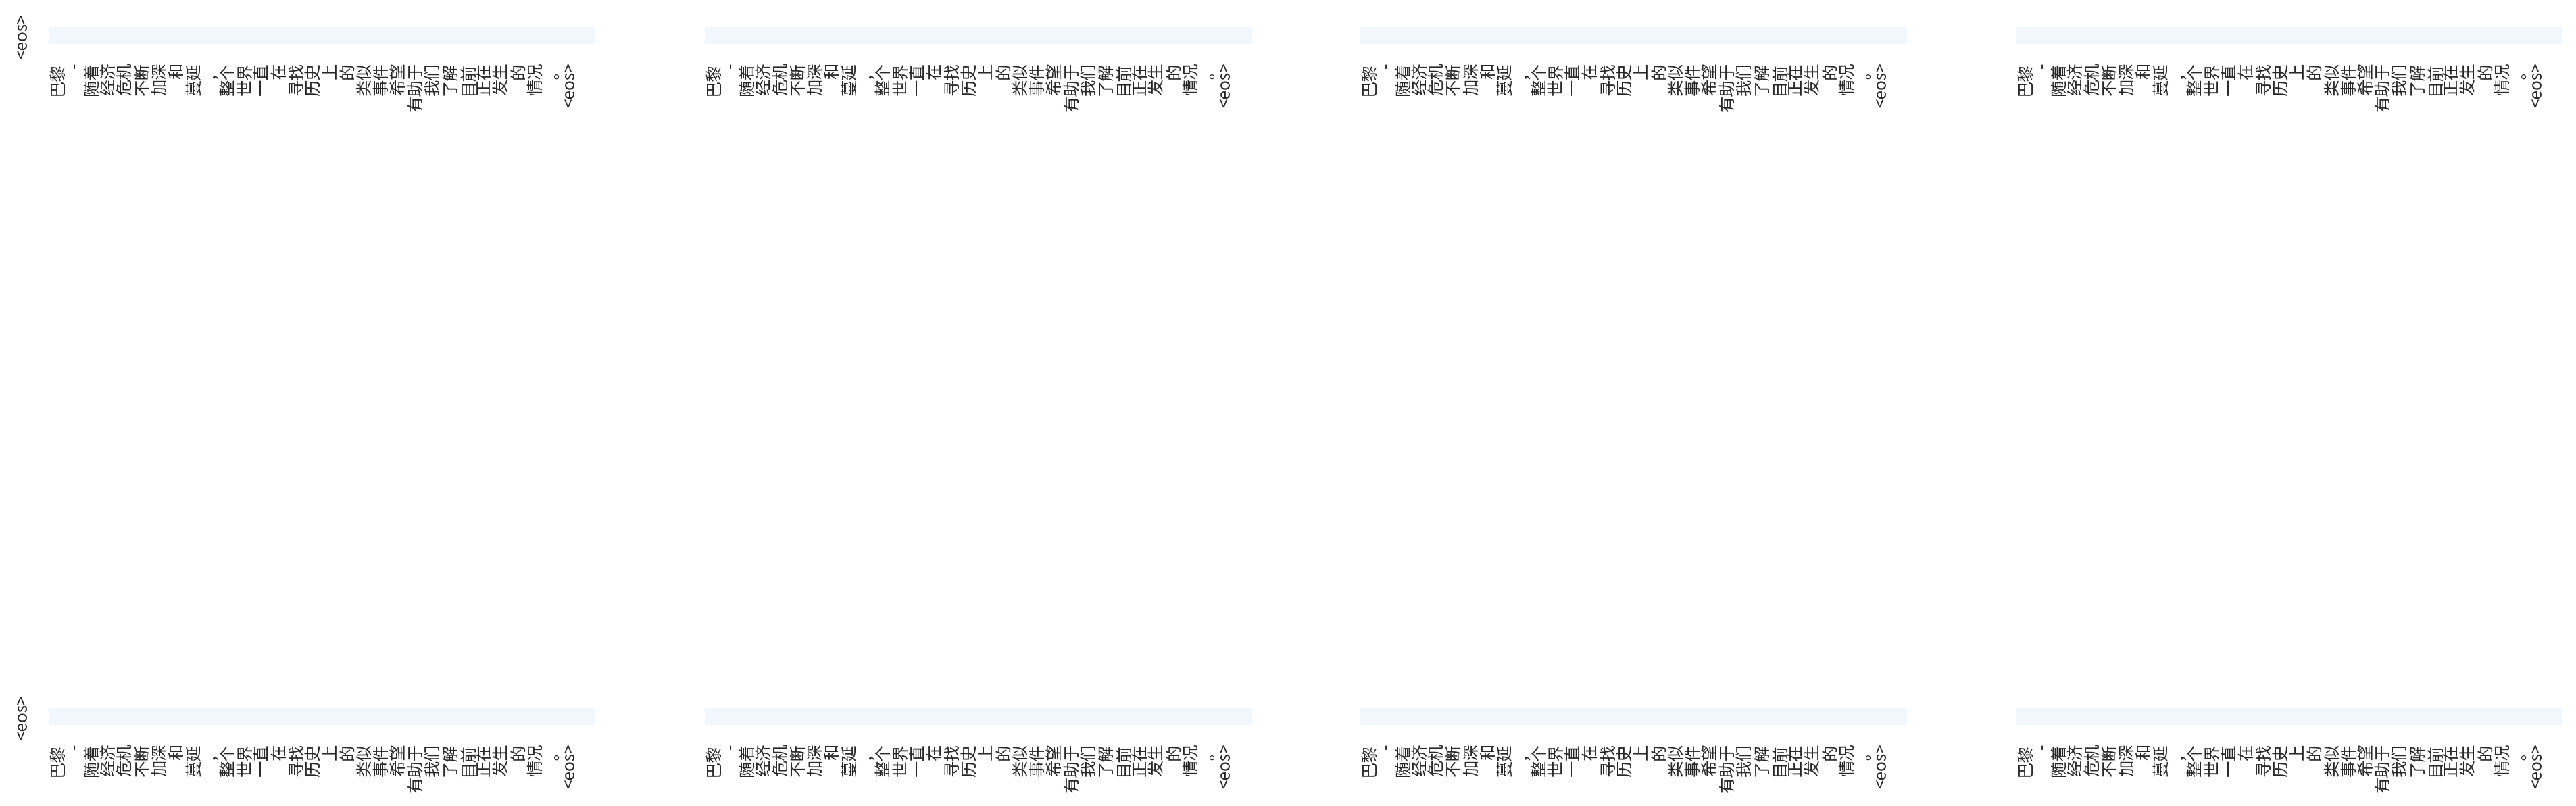

In [47]:
example_idx = 0

source = data.iloc[example_idx][0]
target = data.iloc[example_idx][1]
predicted, attention_scores = greedy_decode(model, source)

print(f'source: {source}\n')
print(f'target: {target}\n')
print(f'predicted: {predicted}\n')

plot_attention_scores(source, predicted, attention_scores)